# Computational Bionics: Project Exercise 2

Group members:
- Yash Waware (12329556)
- Julian Lork (12243805)
- Florian Frech (12308544)

In [1]:
!pip3 install numpy
!pip3 install matplotlib
!pip3 install sympy
!pip3 install pandas
!pip3 install xlrd
!pip3 install scipy

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

## Task 1: Basic System Model
## 1.1 Description

The following section considers the combination of the sub models of the leg and the **hip drive**.

A PID controller which controls the hip angle according to the provided gait data.
The model only considers the swing phase. The simulation is started at toe off and stops when the leg has ground contact again. In the swing phase there are no acting ground reaction forces and foot moments.

An ideal digital controller (no quantization) with a sampling time of $dt = 0.1$ seconds is used.
$$f = \frac{1}{dt} = 10 Hz$$

Further, an ideal analog sensor for the hip and knee angle is used. The hip and knee angles $q_1$ and $q_2$ are directly used without quantization.

A simple ideal damper in the knee is used to stabilize the system:
$$M_2 = D \cdot \omega_2$$

**PID Controller**

We consider the classic PID (Proprtional-Integrating-Differential) controller

$$u(t) = K_p e(t) + K_I \int e(t) dt + K_D \frac{de(t)}{dt}$$

$$G_R(s) = K_P + \frac{K_I}{s} + K_D s = \frac{K_D s^2 + K_P s + K_I}{s}$$

 - $K_P$: controller gain
 - $K_I$: integrator gain
 - $K_D$: differentiator gain

## 1.2 Simplified Box Model

<div style="width: 70%; margin: auto;">
    <img src="BoxModelTask1.png" alt="Box Model Task 1">
</div>

## 1.3 Simulation

### Parameters

In [3]:
from dataclasses import dataclass

GRAVITY = 9.81

@dataclass
class AnthropometricData:
    mass:          float|None = None
    length:        float|None = None
    com:           float|None = None
    r_gyration:    float|None = None
    damping_coeff: float|None = None
    mom_inertia:   float|None = None


@dataclass
class LegModelParam:
    tigh:  AnthropometricData
    shank: AnthropometricData
    foot:  AnthropometricData
    body: AnthropometricData


tigh = AnthropometricData(
    mass=9.73,
    length=0.41,
    com=0.205,
    r_gyration=0.132,
    damping_coeff=0.1,
    mom_inertia=0.1695,
)

shank = AnthropometricData(
    mass=5.07,
    length=0.415,
    com=0.2075,
    r_gyration=0.125,
    mom_inertia=0.0792,
    damping_coeff=0.1,
)

foot = AnthropometricData(
    mass=0.44,
)

body = AnthropometricData(
    mass=100.0,
)

leg_model_param = LegModelParam(
    tigh=tigh,
    shank=shank,
    foot=foot,
    body=body,
)

### Leg Model Equations by Euler-Lagrange formulation

<div style="width: 40%;">
    <img src="LowerLimb.png" alt="Lower Limb">
</div>

In [4]:
import sympy as sp
from sympy import Matrix, sin, cos, latex
from IPython.display import display, Math

# Define the symbolic variables
q1, q2, omega1, omega2 = sp.symbols(r'q_1 q_2 \omega_1 \omega_2')
dot_omega1, dot_omega2 = sp.symbols(r'\dot{\omega}_1 \dot{\omega}_2')
l1, l2, L1, L2 = sp.symbols(r'l_1 l_2 L_1 L_2')
m1, m2, m3 = sp.symbols(r'm_1 m_2 m_3')
J1, J2 = sp.symbols(r'J_1 J_2')
t, g = sp.symbols('t g')

q1 = sp.Function('q_1')(t)
q2 = sp.Function('q_2')(t)

w1 = q1.diff(t)
w2 = q2.diff(t)

dot_w1 = w1.diff(t)
dot_w2 = w2.diff(t)

# Position of the center of mass for tigh, shank and foot
r1 = Matrix([l1 * sin(q1),
             -l1 * cos(q1)])

r2 = Matrix([L1 * sin(q1) + l2 * sin(q2),
             -L1 * cos(q1) - l2 * cos(q2)])

r3 = Matrix([L1 * sin(q1) + L2 * sin(q2),
            -L1 * cos(q1) - L2 * cos(q2)])

# Velocity of the center of mass for tigh, shank and foot
v1 = r1.diff(t)
v2 = r2.diff(t)
v3 = r3.diff(t)

# Kinetic energy of the system
T1 = 0.5 * m1 * v1.dot(v1) + 0.5 * J1 * q1.diff(t)**2
T2 = 0.5 * m2 * v2.dot(v2) + 0.5 * J2 * q2.diff(t)**2
T3 = 0.5 * m3 * v3.dot(v3)

T_total = T1 + T2 + T3

# Potential energy of the system
h1 = -l1 * cos(q1)
h2 = -L1 * cos(q1) - l2 * cos(q2)
h3 = -L1 * cos(q1) - L2 * cos(q2)

V1 = m1 * g * h1
V2 = m2 * g * h2
V3 = m3 * g * h3

V_total = V1 + V2 + V3

L = T_total - V_total

dL_d_dot_q1 = L.diff(q1.diff(t))
dL_d_dot_q2 = L.diff(q2.diff(t))

dL_d_dot_q1_dt = dL_d_dot_q1.diff(t)
dL_d_dot_q2_dt = dL_d_dot_q2.diff(t)

dL_dq1 = L.diff(q1)
dL_dq2 = L.diff(q2)

# Substitute the values of the parameters
subsDict = {q1.diff(t): omega1,
            q2.diff(t): omega2,
            q1.diff(t, 2): dot_omega1,
            q2.diff(t, 2): dot_omega2,}

####################################################################################
# External forces are now our Torque by the driving motor and a damping in the knee
####################################################################################
M_motor = sp.symbols(r'M_{motor}')
D = sp.symbols(r'D_{knee}')
Q1 = M_motor
Q2 = -D * q2.diff(t)
####################################################################################

eq1 = dL_d_dot_q1_dt - dL_dq1 - Q1
eq2 = dL_d_dot_q2_dt - dL_dq2 - Q2

eq1 = eq1.subs(subsDict).simplify()
eq2 = eq2.subs(subsDict).simplify()

sol = sp.solve([eq1, eq2], [dot_omega1, dot_omega2])

dot_omega1_sol = sol[dot_omega1].simplify()
dot_omega2_sol = sol[dot_omega2].simplify()

subsDict = {
    m1: leg_model_param.tigh.mass,
    L1: leg_model_param.tigh.length,
    l1: leg_model_param.tigh.com,
    J1: leg_model_param.tigh.mom_inertia,
    m2: leg_model_param.shank.mass,
    L2: leg_model_param.shank.length,
    l2: leg_model_param.shank.com,
    J2: leg_model_param.shank.mom_inertia,
    m3: leg_model_param.foot.mass,
    g : GRAVITY,
}

dot_omega1_sol = dot_omega1_sol.subs(subsDict)
dot_omega2_sol = dot_omega2_sol.subs(subsDict)

dot_omega1_func = sp.lambdify((q1, q2, omega1, omega2, M_motor, D), dot_omega1_sol, 'numpy')
dot_omega2_func = sp.lambdify((q1, q2, omega1, omega2, M_motor, D), dot_omega2_sol, 'numpy')

### Extracting measurement data

In [5]:
import pandas as pd
import numpy as np

# Read gait data
filename = 'gait_data.xls'
gait_data = pd.read_excel(filename, engine='xlrd', )

# Extract gait data
gait_step = np.array(gait_data["gait"][1:]) / 100

GRFz = np.array(gait_data["GRFz"][1:]) * leg_model_param.body.mass
GRFx = gait_data["GRFx"][1:] * leg_model_param.body.mass

MX_H = np.array(gait_data["MX_H"][1:]) * leg_model_param.body.mass
MX_K = np.array(gait_data["MX_K"][1:]) * leg_model_param.body.mass
MX_F = np.array(gait_data["MX_F"][1:]) * leg_model_param.body.mass

q1_gait_deg = np.array(gait_data["Flex_Ext_H"][1:], dtype=float)
q2_gait_deg = np.array(gait_data["Flex_Ext_K"][1:], dtype=float)

# Preprocess angles of hip & knee
q1_gait = 90 - q1_gait_deg
q2_gait = q1_gait + q2_gait_deg - 180

q1_gait = np.deg2rad(q1_gait)
q2_gait = np.deg2rad(q2_gait)

### Identifying swing-phase

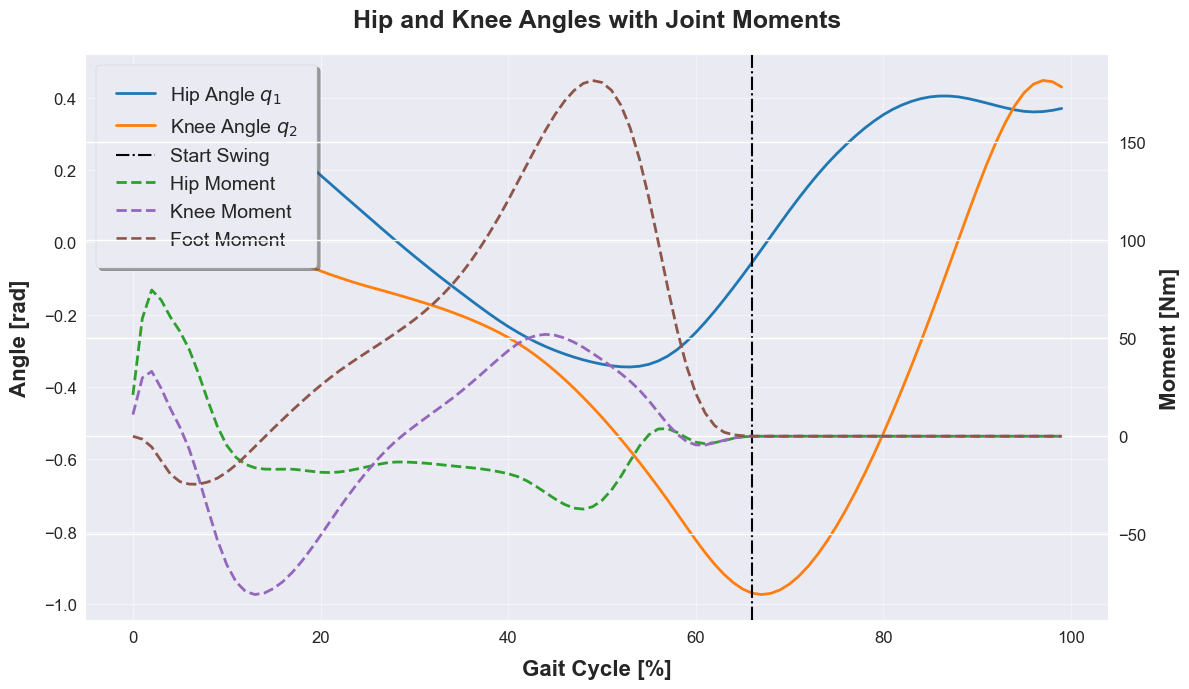

In [6]:
import matplotlib.pyplot as plt

# Extracting swing phase range
tol = 1e-1
matching_indices = np.where(np.abs(MX_F) < tol)[0]
segments = np.split(matching_indices, np.where(np.diff(matching_indices) > 1)[0] + 1)
longest_segment = max(segments, key=len)
swing_range = longest_segment


fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot hip and knee angles on the primary y-axis
ax1.plot(q1_gait, label='Hip Angle $q_1$', color='tab:blue', linewidth=2)
ax1.plot(q2_gait, label='Knee Angle $q_2$', color='tab:orange', linewidth=2)
ax1.axvline(swing_range[0], color='k', linestyle='-.', linewidth=1.5, label='Start Swing')
ax1.grid(which='both', alpha=.45)

# Styling the primary y-axis
ax1.set_xlabel('Gait Cycle [%]', fontsize=16, labelpad=10, fontweight='bold')
ax1.set_ylabel('Angle [rad]', fontsize=16, labelpad=10, fontweight='bold')
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

ax2 = ax1.twinx()

# Plot joint moments on the secondary y-axis
ax2.plot(MX_H, label='Hip Moment', color='tab:green', linestyle='--', linewidth=2)
ax2.plot(MX_K, label='Knee Moment', color='tab:purple', linestyle='--', linewidth=2)
ax2.plot(MX_F, label='Foot Moment', color='tab:brown', linestyle='--', linewidth=2)
ax2.set_ylabel('Moment [Nm]', fontsize=16, labelpad=10, fontweight='bold')
ax2.tick_params(axis='y', labelsize=12)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=14, frameon=True, shadow=True, borderpad=1)

# Add a title with enhanced font properties
plt.title('Hip and Knee Angles with Joint Moments', fontsize=18, fontweight='bold', pad=20)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


### Defining Leg-Model

In [7]:
def leg_model(t, y, M_motor, D):
    omega1, omega2, q1, q2 = y
    domega1 = dot_omega1_func(q1, q2, omega1, omega2, M_motor, D)
    domega2 = dot_omega2_func(q1, q2, omega1, omega2, M_motor, D)
    dq1 = omega1
    dq2 = omega2
    return [domega1, domega2, dq1, dq2]

### Defining Motor-Model

In [8]:
U_M = 16 # V - motor voltage
U_rated = 48 # V - rated voltage
R_M = 0.151 # Ohm - resistance
L_M = 121e-6 # H - inductance
n_0 = 12916 # rpm - no load speed
w_0 = 2 * np.pi * n_0 / 60 # rad/s
k_n = n_0 * 2 * np.pi / (60 * U_rated) # rad/(Vs) - speed constant
k_M = 0.03 # Nm/A - torque constant
i_G = 60 # gear ratio
eta_G = 0.85 # gear efficiency

def drive_model(t, y, u_control, omega):
    M = y
    U = U_M * u_control
    n = i_G * omega * 30 / np.pi
    I = M / (k_M * i_G * eta_G)
    dI = (U - R_M * I - n / k_n) / L_M
    dM = eta_G * i_G * k_M * dI
    return [dM]

### Defining System-Model

In [9]:
def system_equations(t,y, D, u_control):
    dydt_leg = leg_model(t, y[0:4], y[4], D)
    dydt_drive = drive_model(t, y[4], u_control, y[0])
    return dydt_leg + dydt_drive

### Implementation of Non-Quantized PID Controller

In [10]:
# Class PID Controller
class PIDController:
    def __init__(self, Kp, Ki, Kd, T):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.T = T
        self.e_km1 = 0
        self.e_km2 = 0
        self.u_km1 = 0
        pass

    def compute_control(self, reference, state):
        e_k = reference - state
        a0 = self.Kp 
        a1 = (self.Ki * self.T - 2 * self.Kd / self.T - self.Kp)
        a2 = self.Kd / self.T

        u_k = self.u_km1 + a0 * e_k + a1 * self.e_km1 + a2 * self.e_km2

        self.u_km1 = u_k
        self.e_km2 = self.e_km1
        self.e_km1 = e_k

        return u_k

### Simulation Handler

In [11]:
from scipy.integrate import solve_ivp

# Initial states from swing phase
q1_swing_phase = q1_gait[swing_range]
q2_swing_phase = q2_gait[swing_range]
dq1_swing_phase = np.gradient(q1_swing_phase)
dq2_swing_phase = np.gradient(q2_swing_phase)

q1_init = q1_swing_phase[0]
q2_init = q2_swing_phase[0]
omega1_init = dq1_swing_phase[0]
omega2_init = dq2_swing_phase[0]
drive_trq_init = 0.0

initial_state = [omega1_init, omega2_init, q1_init, q2_init, drive_trq_init]

# Simulation and Contoller configuration
dt_control = 1e-1
dt_sim = 1e-2
t_end = len(swing_range) * dt_control
t_control = np.arange(.0, t_end, dt_control)
num_steps = len(t_control)


def reference_q1(time):
    return q1_swing_phase[int(time / dt_control)]

def reference_q2(time):
    return q2_swing_phase[int(time / dt_control)]


def simulation(pid_params):
    Kp, Ki, Kd, D = pid_params
    controller = PIDController(Kp, Ki, Kd, dt_control)

    t_total = []
    y_total = []
    ref_arr = []
    ref2_arr = []

    current_state = initial_state

    for i in range(num_steps):
        current_time = t_control[i]
        reference = reference_q1(current_time)
        referenceq2 = reference_q2(current_time)
        u_control = controller.compute_control(reference, current_state[2])

        t_span = [current_time, min(current_time + dt_control, t_end)]
        t_eval = np.linspace(t_span[0], t_span[1], int((t_span[1]-t_span[0]) / dt_sim) + 1)

        sol = solve_ivp(system_equations, t_span, current_state, args=(D, u_control), t_eval=t_eval, method='BDF', dense_output=True)
        current_state = sol.y[:, -1]

        t_total.append(sol.t)
        y_total.append(sol.y)
        ref_arr.append(reference)
        ref2_arr.append(referenceq2)

    return t_total, y_total, ref_arr, ref2_arr


def post_process(sol_t, sol_y, sol_ref, sol_ref2):
    time        = []
    omega1      = []
    omega2      = []
    q1          = []
    q2          = []
    drive_trq   = []
    ref_q1      = []
    ref_q2      = []

    for t_span, y_span, ref, ref2 in zip(sol_t, sol_y, sol_ref, sol_ref2):
        omega1_span, omega2_span, q1_span, q2_span, drive_trq_span = y_span
        time.extend(t_span)
        omega1.extend(omega1_span)
        omega2.extend(omega1_span)
        q1.extend(q1_span)
        q2.extend(q2_span)
        drive_trq.extend(drive_trq_span)
        ref_q1.extend(np.ones_like(t_span)*ref)
        ref_q2.extend(np.ones_like(t_span) * ref2)


    return np.array(time), np.array(omega1), np.array(omega2), np.array(q1), np.array(q2), np.array(drive_trq), np.array(ref_q1), np.array(ref_q2)




### Simulation Run with initial guess

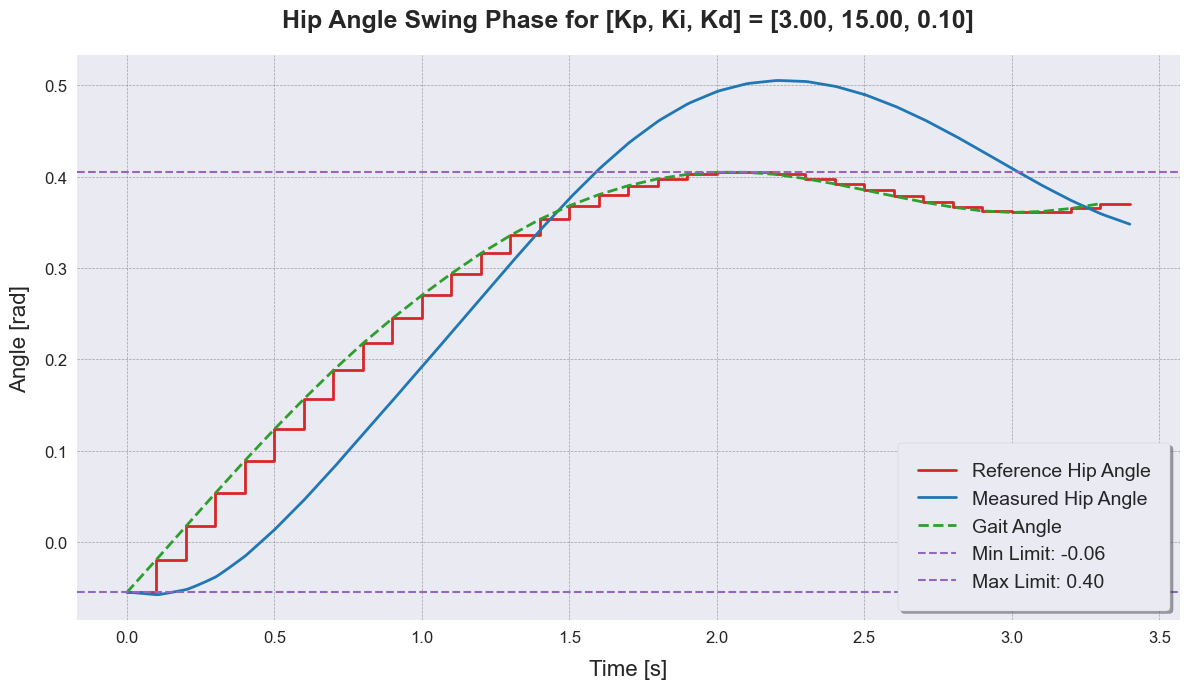

In [12]:
# Initial guess
Kp = 3
Ki = 15
Kd = 0.1
D = 0.8

sim_result = simulation([Kp, Ki, Kd, D])
t_out, omega1_out, omega2_out, q1_out, q2_out, drive_trq_out, ref_q1_out, ref_q2_out = post_process(*sim_result)


plt.figure(figsize=(12, 7))

plt.plot(t_out, ref_q1_out, label='Reference Hip Angle', color='tab:red', linewidth=2)
plt.plot(t_out, q1_out, label='Measured Hip Angle', color='tab:blue', linewidth=2)
plt.plot(t_control, q1_swing_phase, label='Gait Angle', linestyle='--', color='tab:green', linewidth=2)

plt.axhline(y=q1_swing_phase.min(), color='tab:purple', linestyle='--', linewidth=1.5, label=f'Min Limit: {q1_swing_phase.min():.2f}')
plt.axhline(y=q1_swing_phase.max(), color='tab:purple', linestyle='--', linewidth=1.5, label=f'Max Limit: {q1_swing_phase.max():.2f}')


plt.xlabel('Time [s]', fontsize=16, labelpad=10)
plt.ylabel('Angle [rad]', fontsize=16, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='lower right', fontsize=14, frameon=True, shadow=True, borderpad=1)

plt.title(f'Hip Angle Swing Phase for [Kp, Ki, Kd] = [{Kp:.2f}, {Ki:.2f}, {Kd:.2f}]', fontsize=18, fontweight='bold', pad=20)

plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


### Simulation run with optimized coefficients

#### Defining Cost-Functions

In [13]:
def cost_function_pid(params, D):
    Kp, Ki, Kd = params
    sim_result = simulation([Kp, Ki, Kd, D])
    t_out, omega1_out, omega2_out, q1_out, q2_out, drive_trq_out, ref_q1_out, ref_q2_out = post_process(*sim_result)

    total_error = np.sum(np.abs(q1_out - ref_q1_out)**2)
    print(f"Kp: {Kp:.2f} Ki: {Ki:.2f} Kd: {Kd:.2f} D: {D:.2f} Error: {total_error:.2f}")

    return total_error

def cost_function_dampening(params, Kp, Ki, Kd):
    D = params[0]
    sim_result = simulation([Kp, Ki, Kd, D])
    t_out, omega1_out, omega2_out, q1_out, q2_out, drive_trq_out, ref_q1_out, ref_q2_out = post_process(*sim_result)

    total_error = np.sum(np.abs(q2_out - ref_q2_out)**2)
    print(f"Kp: {Kp:.2f} Ki: {Ki:.2f} Kd: {Kd:.2f} D: {D:.2f} Error: {total_error:.2f}")

    return total_error


#### Optimization of PID-Coefficients

In [14]:
from scipy.optimize import minimize

# Initial values for the PID parameters Kp, Ki, Kd
Kp = 3
Ki = 15
Kd = 0.1
D = 0.8

initial_params = [Kp, Ki, Kd]

# bounds for the PID parameters
bounds = [(0, 500), (0, 500), (0, 500)]
result = minimize(cost_function_pid, initial_params, args=(D), bounds=bounds, method='L-BFGS-B')

# Optimized PID parameters
Kp, Ki, Kd = result.x

Kp: 3.00 Ki: 15.00 Kd: 0.10 D: 0.80 Error: 1.80
Kp: 3.00 Ki: 15.00 Kd: 0.10 D: 0.80 Error: 1.80
Kp: 3.00 Ki: 15.00 Kd: 0.10 D: 0.80 Error: 1.80
Kp: 3.00 Ki: 15.00 Kd: 0.10 D: 0.80 Error: 1.80
Kp: 4.30 Ki: 15.20 Kd: 0.00 D: 0.80 Error: 0.29
Kp: 4.30 Ki: 15.20 Kd: 0.00 D: 0.80 Error: 0.29
Kp: 4.30 Ki: 15.20 Kd: 0.00 D: 0.80 Error: 0.29
Kp: 4.30 Ki: 15.20 Kd: 0.00 D: 0.80 Error: 0.29
Kp: 4.32 Ki: 15.19 Kd: 0.00 D: 0.80 Error: 0.29
Kp: 4.32 Ki: 15.19 Kd: 0.00 D: 0.80 Error: 0.29
Kp: 4.32 Ki: 15.19 Kd: 0.00 D: 0.80 Error: 0.29
Kp: 4.32 Ki: 15.19 Kd: 0.00 D: 0.80 Error: 0.29
Kp: 4.38 Ki: 15.14 Kd: 0.00 D: 0.80 Error: 0.28
Kp: 4.38 Ki: 15.14 Kd: 0.00 D: 0.80 Error: 0.28
Kp: 4.38 Ki: 15.14 Kd: 0.00 D: 0.80 Error: 0.28
Kp: 4.38 Ki: 15.14 Kd: 0.00 D: 0.80 Error: 0.28
Kp: 4.64 Ki: 14.92 Kd: 0.00 D: 0.80 Error: 0.26
Kp: 4.64 Ki: 14.92 Kd: 0.00 D: 0.80 Error: 0.26
Kp: 4.64 Ki: 14.92 Kd: 0.00 D: 0.80 Error: 0.26
Kp: 4.64 Ki: 14.92 Kd: 0.00 D: 0.80 Error: 0.26
Kp: 5.66 Ki: 14.08 Kd: 0.00 D: 0.80 Erro

#### Optimization of Dampening coefficient

In [15]:
from scipy.optimize import minimize

D = 0.8
initial_params = [D]

# bounds for the PID parameters
bounds = [(-5, 15)]
result = minimize(cost_function_dampening, initial_params, args=(Kp, Ki, Kd), bounds=bounds, method='L-BFGS-B')

# Optimized PID parameters
D = result.x[0]

Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Error: 137.81
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Error: 137.81
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: -5.00 Error: 13075350.78
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: -5.00 Error: 13076635.20
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Error: 137.81
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Error: 137.81
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Error: 137.81
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Error: 137.81
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Error: 137.81
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Error: 137.81
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Error: 137.81
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Error: 137.81
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Error: 137.81
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Error: 137.81
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Error: 137.81
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Error: 137.81
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Error: 137.81
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Error: 137.81
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Error: 137.81
Kp: 22.83 Ki: 4.33 Kd: 0.00 D: 0.80 Er

#### Simulation-Run

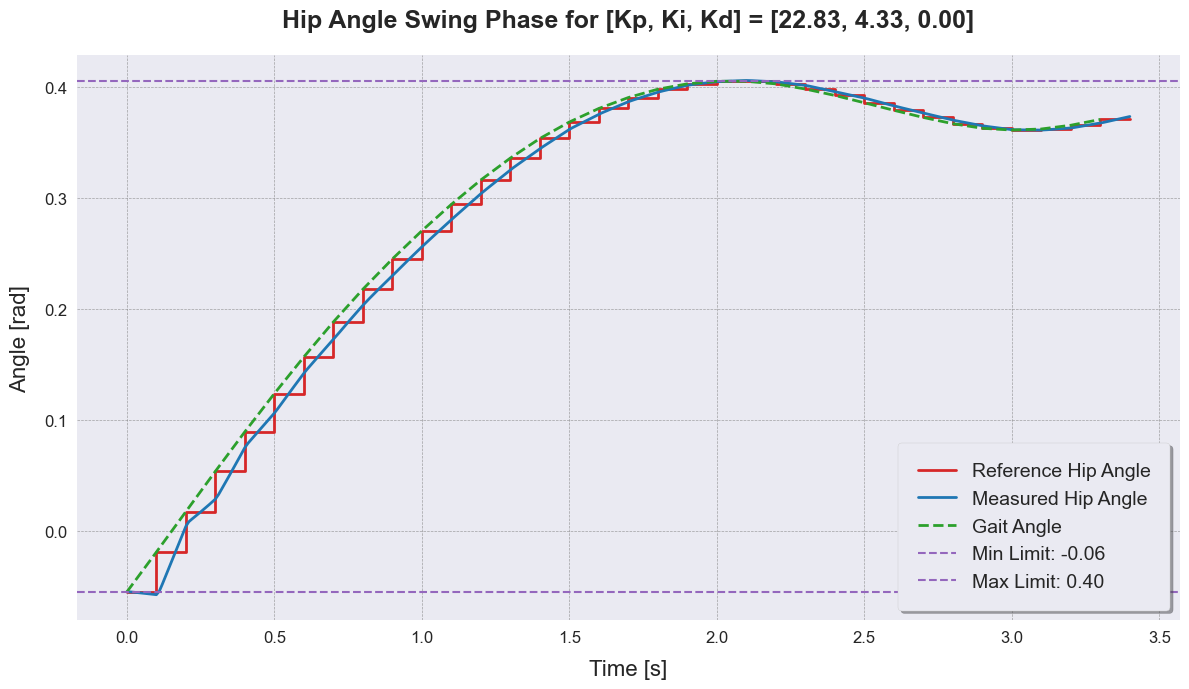

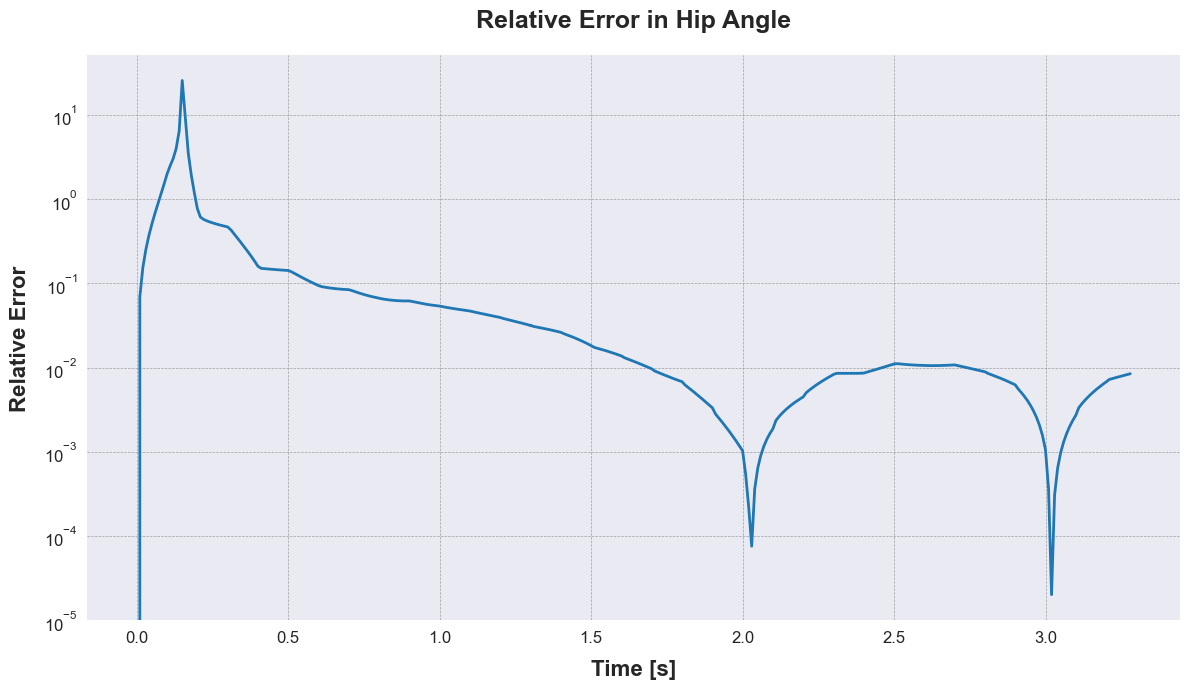

In [16]:
from scipy.interpolate import interp1d

# Optimized parameters
Kp = 22.82771654767414
Ki = 4.332696621261314
Kd = .0
D = 0.7999999911747536

sim_result = simulation([Kp, Ki, Kd, D])
t_out, omega1_out, omega2_out, q1_out, q2_out, drive_trq_out, ref_q1_out, ref_q2_out = post_process(*sim_result)


plt.figure(figsize=(12, 7))

plt.plot(t_out, ref_q1_out, label='Reference Hip Angle', color='tab:red', linewidth=2)
plt.plot(t_out, q1_out, label='Measured Hip Angle', color='tab:blue', linewidth=2)
plt.plot(t_control, q1_swing_phase, label='Gait Angle', linestyle='--', color='tab:green', linewidth=2)

plt.axhline(y=q1_swing_phase.min(), color='tab:purple', linestyle='--', linewidth=1.5, label=f'Min Limit: {q1_swing_phase.min():.2f}')
plt.axhline(y=q1_swing_phase.max(), color='tab:purple', linestyle='--', linewidth=1.5, label=f'Max Limit: {q1_swing_phase.max():.2f}')


plt.xlabel('Time [s]', fontsize=16, labelpad=10)
plt.ylabel('Angle [rad]', fontsize=16, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='lower right', fontsize=14, frameon=True, shadow=True, borderpad=1)

plt.title(f'Hip Angle Swing Phase for [Kp, Ki, Kd] = [{Kp:.2f}, {Ki:.2f}, {Kd:.2f}]', fontsize=18, fontweight='bold', pad=20)

plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()



# Relative Error Measured vs. Gait Hip Angle
q1_swing_interp = interp1d(t_control, q1_swing_phase)
q1_swing_interp_vals = q1_swing_interp(t_out[:-13])
relative_error = np.abs(q1_out[:-13] - q1_swing_interp_vals) / np.abs(q1_swing_interp_vals)

plt.figure(figsize=(12, 7))
plt.semilogy(t_out[:-13], relative_error, label='Relative Error', color='tab:blue', linewidth=2)
plt.xlabel('Time [s]', fontsize=16, fontweight='bold', labelpad=10)
plt.ylabel('Relative Error', fontsize=16, fontweight='bold', labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Relative Error in Hip Angle', fontsize=18, fontweight='bold', pad=20)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


## 1.4 Results

- Reference Hip angle follows gait angle for controller interval
- Offset for initial conditions: controller needs to swing in
- For 0.5 seconds the resulting angle follows the reference angle with reduced error
- Measured hip angles stays within the range of the reference hip angle
- Controller is able to follow the reference angle

## 1.5 Validation Concept of the Basic System Model

 - **Comparison with gait data** (elative error for hip angle)
 - **Stability Analysis:** Small changes in the initial conditions should not lead to large changes in the system behavior
 - Small deviations in the input should lead to small deviations in the output
 - **Step Response Analysis:** The system should react to fast input changes with a smooth response (no overshoot, no oscillations)
 - **Physical Testing:** Compare the simulation results with real world data
 - Comparison with other models

## Task 2: Real Sensor

## 2.1 Description

The controller output is now quantized.

The hip angle is measured using a potentiometer.

An ADC with an input range of 0 to 3 V is considered.

Measurement noises in the sensor with a standard deviation of $\sigma = 10 \space mV$ are taken into account.

| Variable | Discription | Value
|----------|----------|---------|
| $U_{out}$    | Output Voltage   | ...|
| $U_{in}$  | Input Voltage   | $5V$|
|$U_{micro}$ |Input Voltage microcontroller | $3V$ |
| $R_{pot}$   | Variable resistance of Potentiometer  | ...|
|$\alpha_{max}$| Angular range of Potentiometer |$270°$|
|$R_{fixed}$ |Fixed resistance | $60k\Omega$ |
|$\Delta \theta_{hip}$ |Knee range of motion| $-7.15 °$ to $23.2 ° = 30.35 °$ |
|$M$ |Microcontroller 8 bit ADC| 0 to 255 |

## 2.2 Updated Simplified Box Model
<div style="width: 70%; margin: auto;">
    <img src="BoxModelTask2.png" alt="Box Model Task 2">
</div>

## 2.3 Equations: Potentiometer in a Measuring Bridge

The potentimeter can be used with a measuring bridge, where $Z_i = R_i$ since there is only equivalent current and $R_1$ and $R_2$ correspond to the potentimeter such that

$$R_{pot} = R_1 + R_2$$

![](MeasuringBridge.png)

The amplifier voltage, which is used as input voltag for the µ-controller is given as:

$$U_a = U_0 \cdot \left( \frac{R_2}{R_1+R_2} - \frac{R_4}{R_3+R_4} \right)$$

Substituting $R_{pot} = R_1 + R_2$ yields:

$$U_a = U_0 \cdot \left( \frac{R_2}{R_{pot}} - \frac{R_4}{R_3+R_4} \right)$$

The resistance of the potentimeter depends linearly on the rotation angle $\theta$. 

$R_1$ and $R_2$ can be rewritten as:

$$R_1 = \frac{\theta}{\Delta\theta} \cdot R_{pot} \quad \quad R_2 = R_{pot} - R_1$$

Inserting these expressions for $R_1$ and $R_2$ yields

$$U_a = U_0 \cdot \left( \frac{R_{pot} - \frac{\theta}{\Delta\theta} \cdot R_{pot} }{R_{pot}} - \frac{R_4}{R_3+R_4} \right)$$

$$U_a = U_0 \cdot \left( 1 - \frac{\theta}{\Delta\theta} - \frac{R_4}{R_3+R_4} \right)$$

Since the the measuring input voltage range must not exceed $3$ V, the resistors $R_3$ and $R_4$ have to be selected such that the maximum and minimum angles to be measured $\theta_{max}$ and $\theta_{min}$ lie within this voltage range.

We only need to use $\frac{\Delta \theta_{hip}}{\alpha_{max}} = \frac{30.35°}{270°} = 11.25 \space \%$ of the available range of the potentiometer.

Hence we can shift the measuring range to the middle of the potentiometer range:

$$\alpha_{pot} = \theta_{hip} - \frac{\theta_{min} + \theta_{max}}{2} + \frac{\alpha_{max}}{2}$$

Thus $\bar \theta_{hip} = \frac{\theta_{min} + \theta_{max}}{2} = 8.025°$ corresponds to the middle of the measuring range $\frac{\alpha_{max}}{2} = 135 °$.

To obtain an output voltage of $\frac{U_{ADC}}{2} = 1.5 \space V$ for $\bar \theta_{hip} = 8.025 °$, we have to choose $R_4$ and $R_3$ as:

$$\frac{R_4}{R_3+R_4} = 0.2 $$

We set $R_4 = 20 \space k\Omega$ and obtain for $R_3$:

$$R_3 = \frac{R_4 - 0.2 \cdot R_4}{0.2} = 4 \cdot R_4 = 80 \space k \Omega$$

Thus, we prevent voltages close to the limits of the measuring range as the input voltage for the PID controller. Voltages close to zero could lead to the controller not being able to control the system properly.

Hence, we obtain for $U_a$:

$$U_a = U_0 \cdot \left( 1 - 0.2 - \frac{\alpha_{pot}}{\alpha_{max}} \right) = U_0 \cdot \left(0.8 - \frac{\alpha_{pot}}{\alpha_{max}} \right)$$

## 2.4 Simulation

### Implementation of ADC

In [17]:
class ADC:
    def __init__(self, lower_rng, upper_rng, res):
        self.lower_range = lower_rng # V
        self.upper_range = upper_rng # V
        self.resolution  = res # bit
        self.delta = (upper_rng - lower_rng) / (2**res)  # Quantization step size


    def convert(self, analogous_val):
        clipped_val = max(self.lower_range, min(analogous_val, self.upper_range))
        quantized_val = self.delta * round(clipped_val / self.delta)
        return quantized_val

### Implementation of Potentiometer

In [18]:
class Potentiometer:
    def __init__(self, U0, R4, R3, alpha_pot_max, theta_rng, adcRes):
        self.U0 = U0
        self.R4 = R4
        self.R3 = R3
        self.frac_max = theta_rng[-1] / alpha_pot_max
        self.alpha_pot_max = alpha_pot_max
        self.adc = ADC(0, 3.0, adcRes)

    def sense(self, theta):
        theta = np.rad2deg(theta)
        Ua = self.U0 * (self.frac_max - theta / self.alpha_pot_max)
        Ua += np.random.normal(0, 10e-3)
        Ua_quantized = self.adc.convert(Ua)
        theta_estimated = (self.frac_max - (Ua_quantized/self.U0)) * self.alpha_pot_max

        return np.deg2rad(theta_estimated), Ua_quantized

### Implementation Quantized PID Controller

In [19]:
# Class PID Controller
class PIDController:
    def __init__(self, Kp, Ki, Kd, T, adc):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.T = T
        self.e_km1 = 0
        self.e_km2 = 0
        self.u_km1 = 0
        self.adc = adc

    def compute_control(self, reference, state):
        e_k = reference - state
        a0 = self.Kp 
        a1 = (self.Ki * self.T - 2 * self.Kd / self.T - self.Kp)
        a2 = self.Kd / self.T

        u_k = self.u_km1 + a0 * e_k + a1 * self.e_km1 + a2 * self.e_km2

        self.u_km1 = self.adc.convert(u_k)
        self.e_km2 = self.e_km1
        self.e_km1 = e_k

        return self.u_km1

### Simulation handler

In [20]:
from scipy.integrate import solve_ivp


q1_swing_phase = q1_gait[swing_range]
q2_swing_phase = q2_gait[swing_range]
dq1_swing_phase = np.gradient(q1_swing_phase)
dq2_swing_phase = np.gradient(q2_swing_phase)

q1_init = q1_swing_phase[0]
q2_init = q2_swing_phase[0]
omega1_init = dq1_swing_phase[0]
omega2_init = dq2_swing_phase[0]
drive_trq_init = 0.0

initial_state = [omega1_init, omega2_init, q1_init, q2_init, drive_trq_init]


dt_control = 1e-1
dt_sim = 1e-2
t_end = len(swing_range) * dt_control
t_control = np.arange(.0, t_end, dt_control)
num_steps = len(t_control)


def reference_q1(time):
    return q1_swing_phase[int(time / dt_control)]

def reference_q2(time):
    return q2_swing_phase[int(time / dt_control)]


def simulation(pid_params,adc, pot):
    Kp, Ki, Kd, D = pid_params
    controller = PIDController(Kp, Ki, Kd, dt_control, adc)

    t_total = []
    y_total = []
    ref_arr = []
    ref2_arr = []
    control = []
    ua_pot = []
    

    current_state = initial_state

    for i in range(num_steps):
        current_time = t_control[i]
        reference = reference_q1(current_time)
        reference, ua_quantized = pot.sense(reference)
        
        referenceq2 = reference_q2(current_time)
        u_control = controller.compute_control(reference, current_state[2])

        t_span = [current_time, min(current_time + dt_control, t_end)]
        t_eval = np.linspace(t_span[0], t_span[1], int((t_span[1]-t_span[0]) / dt_sim) + 1)

        sol = solve_ivp(system_equations, t_span, current_state, args=(D, u_control), t_eval=t_eval, method='BDF', dense_output=True)
        current_state = sol.y[:, -1]

        t_total.append(sol.t)
        y_total.append(sol.y)
        ref_arr.append(reference)
        ref2_arr.append(referenceq2)
        control.append(u_control)
        ua_pot.append(ua_quantized)

    return t_total, y_total, ref_arr, ref2_arr, control, ua_pot


def post_process(sol_t, sol_y, sol_ref, sol_ref2, control, ua_potentiometer):
    time        = []
    omega1      = []
    omega2      = []
    q1          = []
    q2          = []
    drive_trq   = []
    ref_q1      = []
    ref_q2      = []
    u_ctrl      = []
    ua_pot      = []


    for t_span, y_span, ref, ref2, ctrl, pote in zip(sol_t, sol_y, sol_ref, sol_ref2, control, ua_potentiometer):
        omega1_span, omega2_span, q1_span, q2_span, drive_trq_span = y_span
        time.extend(t_span)
        omega1.extend(omega1_span)
        omega2.extend(omega1_span)
        q1.extend(q1_span)
        q2.extend(q2_span)
        drive_trq.extend(drive_trq_span)
        u_ctrl.extend(np.ones_like(t_span)*ctrl)
        ua_pot.extend(np.ones_like(t_span)*pote)
        ref_q1.extend(np.ones_like(t_span)*ref)
        ref_q2.extend(np.ones_like(t_span) * ref2)


    return np.array(time), np.array(omega1), np.array(omega2), np.array(q1), np.array(q2), np.array(drive_trq), np.array(ref_q1), np.array(ref_q2), np.array(u_ctrl), np.array(ua_pot)




### Configuration of Potentiometer

In [21]:
import math

# Potentiometer setup
flex_Ext_H_deg = np.array(gait_data["Flex_Ext_H"][1:], dtype=float)
theta_max = np.max(flex_Ext_H_deg)
theta_min = np.min(flex_Ext_H_deg)
ALPHA_POT_MAX = 270.0

frac_min = theta_min / ALPHA_POT_MAX
frac_max = theta_max / ALPHA_POT_MAX

R4 = 20e3 # 10 kOhm
R3 = (1 - frac_min) / frac_min * R4
R3 = math.ceil(R3 / 10000) * 10000
U0 = 5

pot = Potentiometer(U0, R4, R3, ALPHA_POT_MAX, (theta_min, theta_max), 10)


### Simulation run with previouly optimized parameters

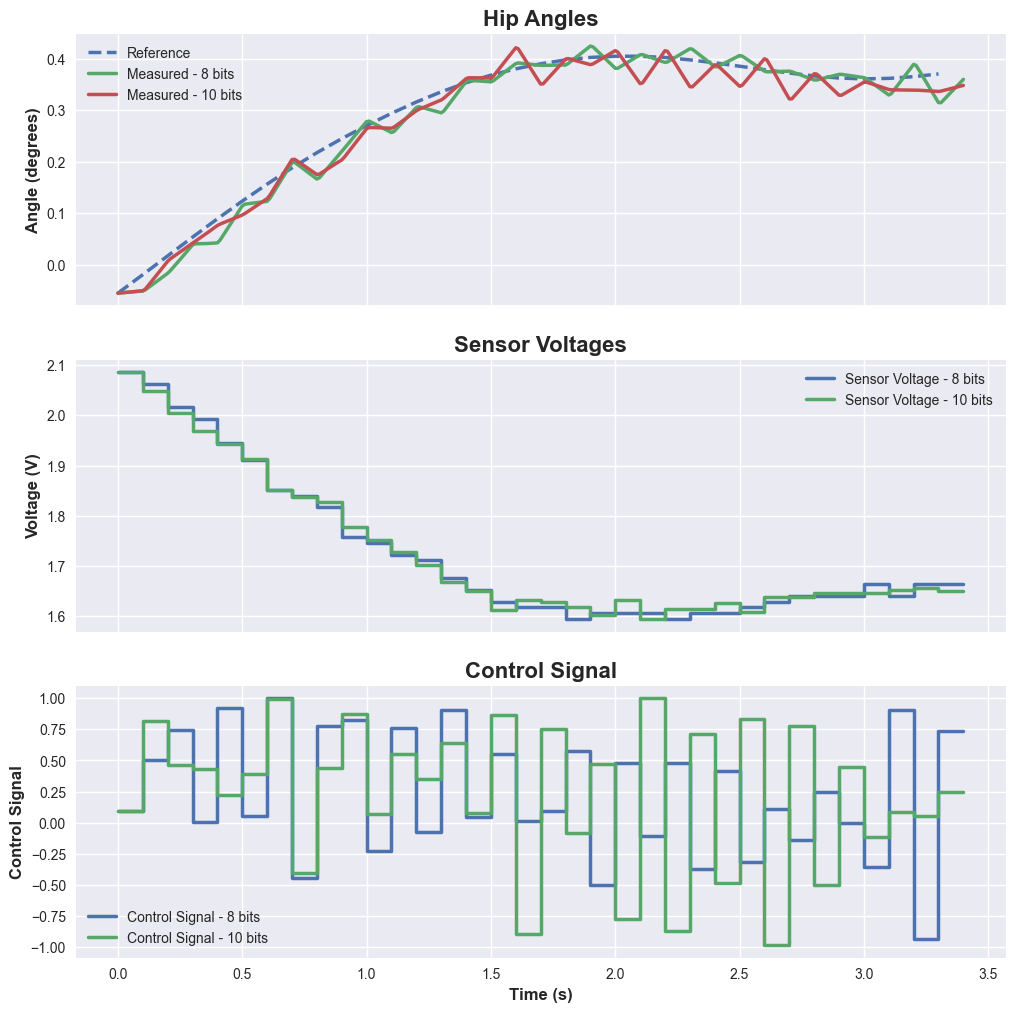

In [22]:
# Optimized parameters
Kp = 22.82771654767414
Ki = 4.332696621261314
Kd = .0
D = 0.7999999911747536


fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
axes[0].plot(t_control, q1_swing_phase, label='Reference', linewidth=2.5, linestyle='dashed')

# 8-bit run
adc = ADC(-1.0, 1.0, 8)
pot = Potentiometer(U0, R4, R3, ALPHA_POT_MAX, (theta_min, theta_max), 8)
sim_result = simulation([Kp, Ki, Kd, D], adc, pot)
t_out, omega1_out, omega2_out, q1_out, q2_out, drive_trq_out, ref_q1_out, ref_q2_out, u_control, ua_potentiometer = post_process(*sim_result)

axes[0].plot(t_out, q1_out, label='Measured - 8 bits', linewidth=2.5)
axes[1].plot(t_out, ua_potentiometer, label='Sensor Voltage - 8 bits', linewidth=2.5)
axes[2].plot(t_out, u_control, label='Control Signal - 8 bits', linewidth=2.5)


# 10-bit run
adc = ADC(-1.0, 1.0, 10)
pot = Potentiometer(U0, R4, R3, ALPHA_POT_MAX, (theta_min, theta_max), 10)
sim_result = simulation([Kp, Ki, Kd, D], adc, pot)
t_out, omega1_out, omega2_out, q1_out, q2_out, drive_trq_out, ref_q1_out, ref_q2_out, u_control, ua_potentiometer = post_process(*sim_result)

axes[0].plot(t_out, q1_out, label='Measured - 10 bits', linewidth=2.5)
axes[1].plot(t_out, ua_potentiometer, label='Sensor Voltage - 10 bits', linewidth=2.5)
axes[2].plot(t_out, u_control, label='Control Signal - 10 bits', linewidth=2.5)

axes[0].set_title('Hip Angles', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Angle (degrees)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True)
axes[1].set_title('Sensor Voltages', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Voltage (V)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True)
axes[2].set_title('Control Signal', fontsize=16, fontweight='bold')
axes[2].set_xlabel('Time (s)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Control Signal', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True)



## 2.5 Results
- Both quantization levels (8-bit and 10-bit) closely follow the reference trajectory
- 10-bit ADC provides smoother and more accurate response due to higher resolution
- 10-bit ADC provides smaller steps in sensor voltages due to higher resolution
- No clear trend observable for control signal
- Due to noise we observe abrupt changes in hip-angles
- Abrupt changes of hip-angles are fed-back into the controller forcing correction in $u_{control}$

# Task 3: Optimization for 10-bit ADC

Though it imposes significantly increased execution time the `differential_evolution` method by scipy provided best optimization results for the noisy signal. The `minimize` method ultimately yielded the initial conditions.

### Defining cost-functions

In [23]:
def cost_function_pid(params, D, adc, pot):
    Kp, Ki, Kd = params
    sim_result = simulation([Kp, Ki, Kd, D], adc, pot)
    t_out, omega1_out, omega2_out, q1_out, q2_out, drive_trq_out, ref_q1_out, ref_q2_out, u_control, ua_potentiometer = post_process(*sim_result)
    total_error = np.sum(np.abs(q1_out - ref_q1_out)**2)

    return total_error

def cost_function_dampening(params, Kp, Ki, Kd, adc, pot):
    D = params[0]
    sim_result = simulation([Kp, Ki, Kd, D], adc, pot)
    t_out, omega1_out, omega2_out, q1_out, q2_out, drive_trq_out, ref_q1_out, ref_q2_out, u_control, ua_potentiometer = post_process(*sim_result)
    total_error = np.sum(np.abs(q2_out - ref_q2_out)**2)

    return total_error


### Optimization of PID-Coefficients

In [24]:
from scipy.optimize import minimize
from scipy.optimize import differential_evolution


# Expected runtime >> 9min!
# Initial values for the PID parameters Kp, Ki, Kd
Kp = 3
Ki = 15
Kd = 0.1
D = 0.8

initial_params = [Kp, Ki, Kd]

# bounds for the PID parameters
bounds = [(0, 500), (0, 500), (0, 500)]
#result = minimize(cost_function, initial_params, args=(D, adc, pot), bounds=bounds, method='L-BFGS-B')
result = differential_evolution(cost_function_pid, bounds, args=(D, adc, pot), tol=0.1, maxiter=500, disp=True)

# Optimized PID parameters
Kp, Ki, Kd = result.x

differential_evolution step 1: f(x)= 39.98520432904417
differential_evolution step 2: f(x)= 9.2750217548535
differential_evolution step 3: f(x)= 9.2750217548535
differential_evolution step 4: f(x)= 9.2750217548535
differential_evolution step 5: f(x)= 2.2799683088334315


KeyboardInterrupt: 

### Optimization of Dampening Coefficient

In [ ]:
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

D = 0.8
initial_params = [D]

# bounds for the PID parameters
bounds = [(0, 10.0)]
#result = minimize(cost_function2, initial_params, args=(Kp, Ki, Kd, adc, pot), bounds=bounds, method='L-BFGS-B')
result = differential_evolution(cost_function_dampening, bounds, args=(Kp, Ki, Kd, adc, pot), maxiter=500, disp=True)

# Optimized PID parameters
D = result.x[0]

### Simulation run with optimized parameters for noisy signal

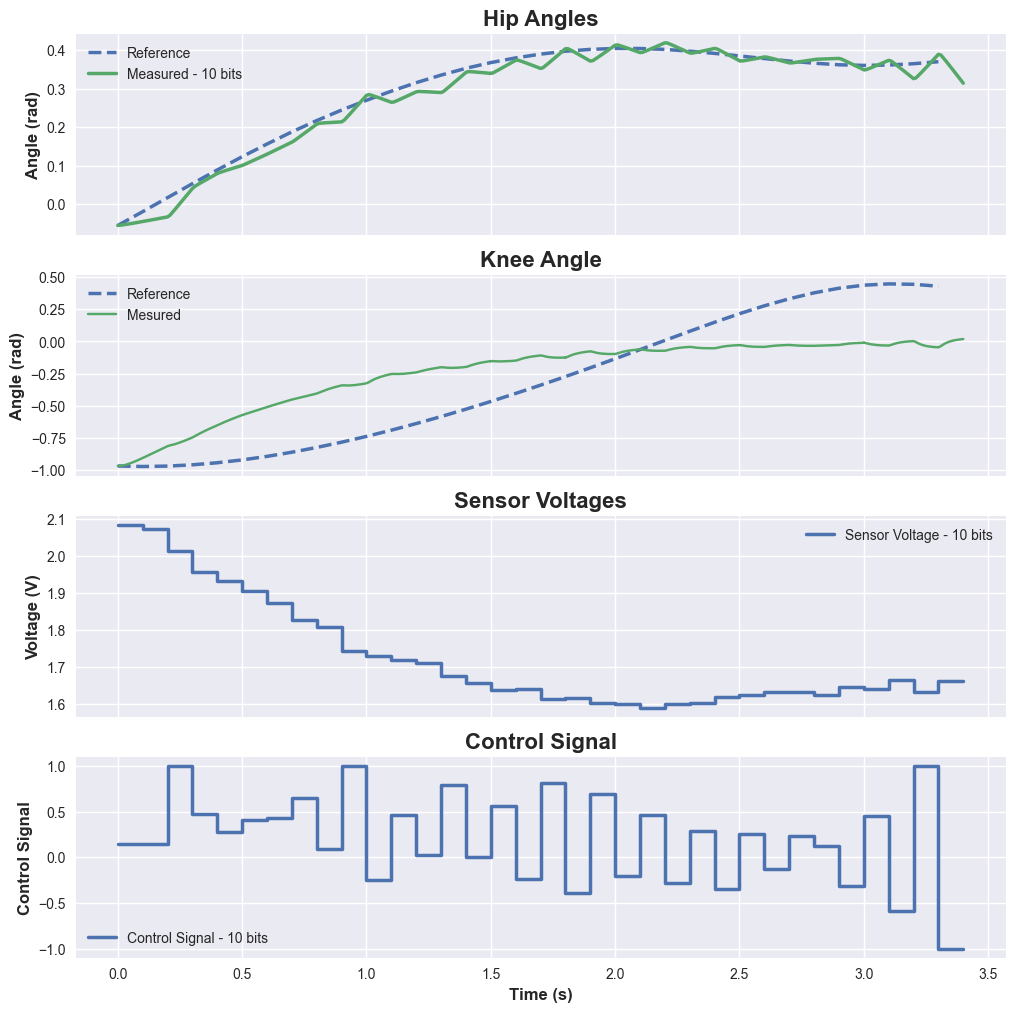

In [25]:
# Optimized parameters
Kp = 20.378864748834815
Ki = 38.561665174539115
Kd = 0.30520090918068377
D = 9.939691571983305

adc = ADC(-1.0, 1.0, 10)
pot = Potentiometer(U0, R4, R3, ALPHA_POT_MAX, (theta_min, theta_max), 10)
sim_result = simulation([Kp, Ki, Kd, D], adc, pot)
t_out, omega1_out, omega2_out, q1_out, q2_out, drive_trq_out, ref_q1_out, ref_q2_out, u_control, ua_potentiometer  = post_process(*sim_result)

fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
axes[0].plot(t_control, q1_swing_phase, label='Reference', linewidth=2.5, linestyle='dashed')
axes[0].plot(t_out, q1_out, label='Measured - 10 bits', linewidth=2.5)
axes[1].plot(t_control, q2_swing_phase, label='Reference', linewidth=2.5, linestyle='dashed')
axes[1].plot(t_out, q2_out, label='Mesured')
axes[2].plot(t_out, ua_potentiometer, label='Sensor Voltage - 10 bits', linewidth=2.5)
axes[3].plot(t_out, u_control, label='Control Signal - 10 bits', linewidth=2.5)


axes[0].set_title('Hip Angles', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Angle (rad)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True)
axes[1].set_title('Knee Angle', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Angle (rad)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True)
axes[2].set_title('Sensor Voltages', fontsize=16, fontweight='bold')
axes[2].set_ylabel('Voltage (V)', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True)
axes[3].set_title('Control Signal', fontsize=16, fontweight='bold')
axes[3].set_xlabel('Time (s)', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Control Signal', fontsize=12, fontweight='bold')
axes[3].legend()
axes[3].grid(True)

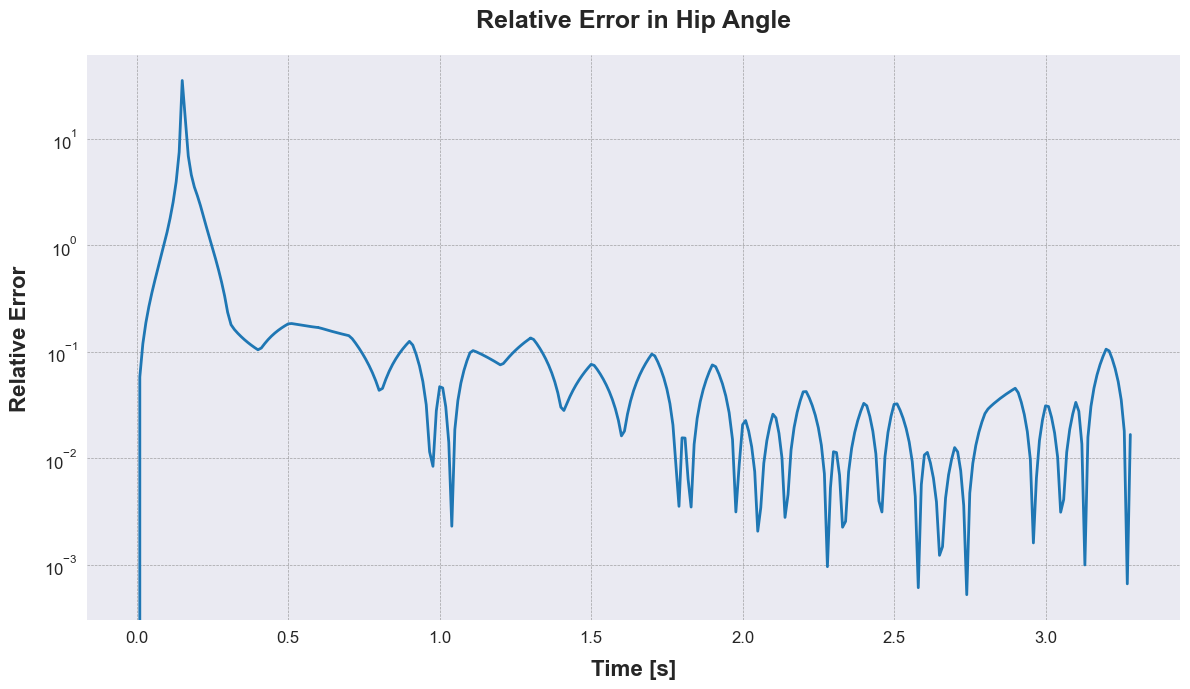

In [26]:
# Relative Error Measured vs. Gait Hip Angle
q1_swing_interp = interp1d(t_control, q1_swing_phase)
q1_swing_interp_vals = q1_swing_interp(t_out[:-13])
relative_error = np.abs(q1_out[:-13] - q1_swing_interp_vals) / np.abs(q1_swing_interp_vals)

plt.figure(figsize=(12, 7))
plt.semilogy(t_out[:-13], relative_error, label='Relative Error', color='tab:blue', linewidth=2)
plt.xlabel('Time [s]', fontsize=16, fontweight='bold', labelpad=10)
plt.ylabel('Relative Error', fontsize=16, fontweight='bold', labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Relative Error in Hip Angle', fontsize=18, fontweight='bold', pad=20)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


### Results
- Offset for initial conditions: controller needs to swing in
- After 0.5 seconds the resulting angle follows the reference angle with reduced error ($<10^{-1}$)
- Due to noise we observe abrupt changes in hip-angles
- Abrupt changes of hip-angles are fed-back into the controller forcing correction in $u_{control}$
- Knee Angle not following the reference angle, possibly due to missing momentum that can be controlled by the simulation
- Optimization tries to increase dampening coefficient to upper bound to mitigate any movement